In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import time
import math

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
tf.__version__

'1.0.0'

### CONFIGURATION OF CNN

In [3]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
data.test.cls = np.argmax(data.test.labels ,axis =1)

In [6]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size ,img_size)
num_channels = 1
num_classes = 10

In [7]:
def plot_images(images , cls_true , cls_pred = None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat) :
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        if cls_pred == None :
            xlabel = 'True:{0}'.format(cls_true[i])
        else :
            xlabel = 'True:{0}, Pred:{1}'.format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [9]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape = [length]))

In [10]:
def new_conv_layer(input ,num_input_channels,filter_size,num_filters,use_pooling=True):
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    weights= new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input =input ,
                        filter = weights ,
                        strides = [1,1,1,1],
                        padding ='SAME')
    layer += biases
    if use_pooling :
        layer = tf.nn.max_pool(value = layer ,
                              ksize =[1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
    layer = tf.nn.relu(layer)
    return layer , weights 

In [11]:
def new_fc_layer(input , num_inputs , num_outputs ,use_relu = True ):
    weights = new_weights(shape = [num_inputs,num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input,weights) + biases
    if use_relu is True :
        layer = tf.nn.relu(layer)
    return layer

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    f = tf.shape(layer)
#     num_features = np.array((np.array(layer_shape[1:4])).astype(int)).prod()
    num_features = int(np.prod(layer_shape[1:4]))
    layer_flat = tf.reshape(layer,[-1,num_features])
    return layer_flat ,num_features

# MODEL

## INPUT TO MODEL

In [13]:
x = tf.placeholder(tf.float32,shape = [None,img_size_flat],name='x')
x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])
#                   [num_images , img_width , img_height , channels]

In [14]:
y_true = tf.placeholder(tf.float32 , shape = [None,10],name='y')
y_true_cls = tf.argmax(y_true,dimension=1)

## MODEL

In [15]:
layer_conv1 , weights_conv1 = new_conv_layer(input = x_image,
                                             num_input_channels=num_channels,
                                             filter_size=filter_size1,
                                             num_filters=num_filters1,
                                             use_pooling=True)

In [16]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [17]:
layer_conv2 , weights_conv2 = new_conv_layer(input = layer_conv1,
                                             num_input_channels=num_filters1,
                                             filter_size=filter_size2,
                                             num_filters=num_filters2,
                                             use_pooling=True)

In [18]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [19]:
layer_flat ,num_features = flatten_layer(layer_conv2)

In [20]:
print num_features , layer_flat

1764 Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)


In [21]:
layer_fc1 = new_fc_layer(input =layer_flat ,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [22]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [23]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [24]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### SOFTMAX

In [25]:
y_pred = tf.nn.softmax(layer_fc2)

In [26]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

### COST FUNCTION 

In [27]:
cross_entropy= tf.nn.softmax_cross_entropy_with_logits(logits =layer_fc2 , labels=y_true)

In [28]:
cost = tf.reduce_mean(cross_entropy)

### OPTIMIZER 

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### PREDICTION & ACCURACY

In [30]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# TENSORFLOW SESSION RUN

In [32]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [33]:
train_batch_size = 128

In [34]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,total_iterations+num_iterations) :
        x_batch,y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x:x_batch,y_true:y_true_batch}
        session.run(optimizer,feed_dict=feed_dict_train)
        
        if i%100 == 0:
            acc = session.run(accuracy,feed_dict=feed_dict_train)
            print 'Accuracy @iter {0:>6} , Training Acc {1}'.format(i+1,acc)
            
    total_iterations += num_iterations
    end_time = time.time()
    print 'Total Time Elapsed :',round(end_time-start_time,3)

In [35]:
def plot_example_errors(cls_pred,correct):
    incorrect = (correct==False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images[:9],cls_true[:9],cls_pred[:9])

In [36]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true = cls_true , y_pred = cls_pred)
    print cm
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [37]:
test_batch_size = 256
def print_accuracy(show_example_errors= False ,show_confusion_matrix = False) :
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test,dtype = np.int)
    i=0
    while(i<num_test) :
        j=min(i + test_batch_size, num_test)
        images = data.test.images[i:j,:]
        labels = data.test.labels[i:j,:]
        feed_dict={x:images,y_true:labels}
        cls_pred[i:j] = session.run(y_pred_cls,feed_dict=feed_dict)
        i=j
        
    cls_true = data.test.cls
    correct = (cls_true==cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum)/num_test
   
    print "Accuracy on Test-Set: {0:.1%} ({1} / {2})".format(acc, correct_sum, num_test)
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

# TRAINING & TESTING

In [38]:
print_accuracy()

Accuracy on Test-Set: 10.3% (1034 / 10000)


### ITERATION 1

In [39]:
optimize(1)

Accuracy @iter      1 , Training Acc 0.109375
Total Time Elapsed : 0.271


In [40]:
print_accuracy()

Accuracy on Test-Set: 11.2% (1120 / 10000)


### ITERATION 999

In [41]:
optimize(999)
print_accuracy()

Accuracy @iter    101 , Training Acc 0.6796875
Accuracy @iter    201 , Training Acc 0.828125
Accuracy @iter    301 , Training Acc 0.9296875
Accuracy @iter    401 , Training Acc 0.875
Accuracy @iter    501 , Training Acc 0.8984375
Accuracy @iter    601 , Training Acc 0.9609375
Accuracy @iter    701 , Training Acc 0.953125
Accuracy @iter    801 , Training Acc 0.9296875
Accuracy @iter    901 , Training Acc 0.9375
Total Time Elapsed : 162.867
Accuracy on Test-Set: 93.7% (9371 / 10000)


Accuracy on Test-Set: 93.7% (9371 / 10000)
Example errors:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


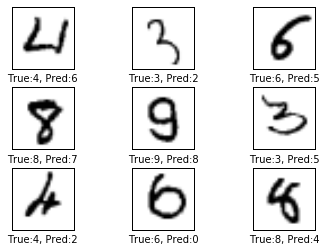

Confusion Matrix:
[[ 968    0    2    2    0    2    3    1    2    0]
 [   0 1108    4    2    0    1    4    0   16    0]
 [  12    1  953   12   14    0    5   12   22    1]
 [   4    1   14  923    1   20    0   15   24    8]
 [   1    2    5    0  930    0   10    1    3   30]
 [  12    2    2   21    7  817    9    1   16    5]
 [  13    3    4    0    9   17  908    1    3    0]
 [   0   11   25    5    6    0    0  945    2   34]
 [  11    2    4   20   10    9    6    9  892   11]
 [  12    5    4   11   27    2    0   11   10  927]]


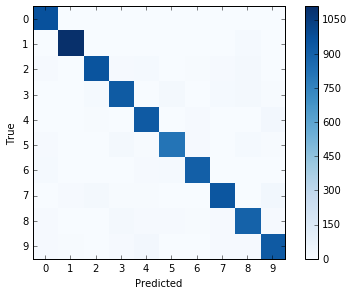

In [42]:
print_accuracy(show_confusion_matrix=True,show_example_errors=True)

In [53]:
session.close()

# USING PRETTYTENSOR

In [43]:
import prettytensor as pt

In [44]:
x_pretty = pt.wrap(x_image)

In [45]:
print type(x_pretty)

<class 'prettytensor.pretty_tensor_class.Layer'>


In [49]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred ,loss = x_pretty.\
        conv2d(kernel=5,depth=16,name='layer_conv1').\
        max_pool(kernel=2,stride=2).\
        conv2d(kernel=5,depth=36,name='layer_conv2').\
        max_pool(kernel=2,stride=2).\
        flatten().\
        fully_connected(size=128,name='layer_fc1').\
        softmax_classifier(num_classes=10,labels=y_true)        

In [50]:
def get_pt_weights(layer_name):
    with tf.variable_scope(layer_name,reuse=True):
        variable = tf.get_variable('weights')
    return variable

In [51]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [56]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [57]:
print_accuracy()

Accuracy on Test-Set: 12.3% (1232 / 10000)


In [58]:
optimize(1)

Accuracy @iter   1001 , Training Acc 0.109375
Total Time Elapsed : 0.315


In [59]:
print_accuracy()

Accuracy on Test-Set: 12.3% (1232 / 10000)


In [60]:
optimize(999)

Accuracy @iter   1101 , Training Acc 0.078125
Accuracy @iter   1201 , Training Acc 0.1171875
Accuracy @iter   1301 , Training Acc 0.109375
Accuracy @iter   1401 , Training Acc 0.125
Accuracy @iter   1501 , Training Acc 0.1328125
Accuracy @iter   1601 , Training Acc 0.125
Accuracy @iter   1701 , Training Acc 0.1328125
Accuracy @iter   1801 , Training Acc 0.09375
Accuracy @iter   1901 , Training Acc 0.125
Total Time Elapsed : 183.404


In [62]:
print_accuracy()

Accuracy on Test-Set: 12.3% (1232 / 10000)
